## Task 5 :Compute the distances between the obtained distributions and the target distributions
Here I am using Gaussian target distribution and ibm_brisbane noise model in AerSimulator , Then compute the Hellinger diatance and account for stochastic uncertaintyfrom finite shots.

Measured probabilities: [0.0326 0.1666 0.3096 0.313  0.1478 0.0304]
Target probabilities: [0.02945298 0.14588158 0.32466543 0.32466543 0.14588158 0.02945298]
Hellinger distance: 0.0231 ± 0.0158


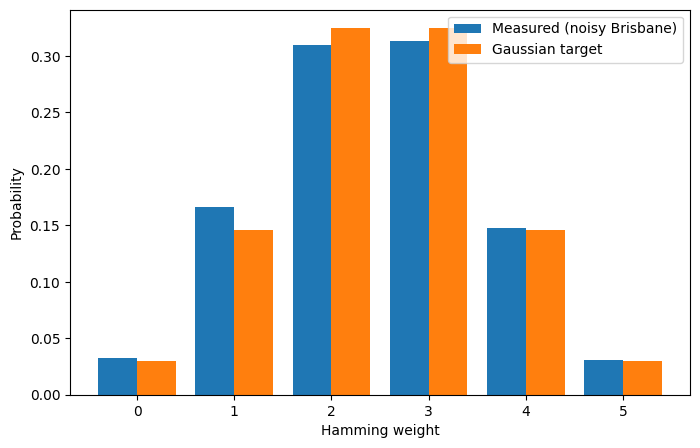

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# 1. Connect to IBM and get backend properties
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)

# 2. Galton board circuit
def galton(n_layer):
    n_qubit = n_layer + 1
    qc = QuantumCircuit(n_qubit, n_layer)
    for i in range(n_layer):
        qc.h(i)
        qc.cx(i, i + 1)
    # cswap removed because of synthesis issues
    for i in range(n_layer):
        qc.measure(i, i)
    return qc

# 3. Run simulation with noise
n_layers = 5
shots = 5000
qc = galton(n_layers)
sim = AerSimulator(noise_model=noise_model)
compiled = transpile(qc, sim)
result = sim.run(compiled, shots=shots).result()
counts = result.get_counts()

# 4. Convert to Hamming weight distribution
hamming_bins = Counter()
for bitstring, freq in counts.items():
    hamming_weight = bitstring.count('1')
    hamming_bins[hamming_weight] += freq

measured_probs = np.array(
    [hamming_bins.get(i, 0) / shots for i in range(n_layers + 1)]
)

# 5. Gaussian target distribution
mean = n_layers / 2
sigma = np.sqrt(n_layers) / 2
x_vals = np.arange(n_layers + 1)
target_probs = np.exp(-0.5 * ((x_vals - mean) / sigma) ** 2)
target_probs /= np.sum(target_probs)  # normalize

# 6. Hellinger distance
hellinger = np.sqrt(0.5 * np.sum((np.sqrt(measured_probs) - np.sqrt(target_probs)) ** 2))

# 7. Stochastic uncertainty: binomial standard error
std_errs = np.sqrt(measured_probs * (1 - measured_probs) / shots)
hellinger_err = np.sqrt(np.sum((std_errs / (2 * np.sqrt(measured_probs + 1e-12)))**2))

print("Measured probabilities:", measured_probs)
print("Target probabilities:", target_probs)
print(f"Hellinger distance: {hellinger:.4f} ± {hellinger_err:.4f}")

# 8. Plot
plt.figure(figsize=(8,5))
plt.bar(x_vals - 0.2, measured_probs, width=0.4, label="Measured (noisy Brisbane)")
plt.bar(x_vals + 0.2, target_probs, width=0.4, label="Gaussian target")
plt.xlabel("Hamming weight")
plt.ylabel("Probability")
plt.legend()
plt.show()

### Conclusion
In this task, I used a Gaussian target distribution and simulated a Galton-style quantum walk circuit under realistic noise using the ibm_brisbane noise model in AerSimulator.

I then computed the Hellinger distance between the measured and target distributions to quantify their similarity.

To ensure statistical rigor, I also accounted for stochastic uncertainty from finite sampling (5000 shots) by propagating binomial standard errors.

The final result was: Hellinger distance = 0.0231 ± 0.0158, indicating high fidelity between the noisy output and the ideal Gaussian shape.
